In [11]:
#!pip install scikit-dsp-comm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import square
from sk_dsp_comm import digitalcom as dc
from sk_dsp_comm import sigsys as ss

In [2]:
def generar_cuadrada(frecuencia, duracion, Muestras, duty_cycle):
    
    t = np.linspace(0, duracion, Muestras, endpoint=False)
    signal_square = square(2 * np.pi * frecuencia * t, duty=duty_cycle)

    # Ajustar el ancho del pulso
    signal_square = 0.5 * (signal_square + 1)  # Escalar y desplazar para ajustar el ancho

    return t, signal_square

#SamplingRate = '{:.2e}'.format(150e6)
Muestras = 100000

print(f"SamplingRate = {Muestras}")

c = 2.988e8             #Velocidad de la luz
Dmin = 2                #Distancia minima que detecta el radar
Dmax = 10               #Distancia maxima que detecta el radar


PRI = (Dmax*2)/c        #Frecuenca de transmision de pulsos del radar [s]
PRF = 1/PRI             #Periodo de transmision de pulsos de radar    [s]
PL = (Dmin*2)/c         #Ancho del pulso a transmitir                 [s]
duracion = PRI
duty_cycle = PL / PRI

# Generar señal cuadrada con parámetros variables
t, signal_square = generar_cuadrada(PRF, duracion, Muestras, duty_cycle)

print(f"Pulse Repetition Interval: PRI = {'{:.2e}'.format(PRI)}\nPulse Repetition Frecuency: PRF = {'{:.2e}'.format(PRF)}\nPulse Length: PL = {'{:.2e}'.format(PL)} - {duty_cycle}")

SamplingRate = 100000
Pulse Repetition Interval: PRI = 6.69e-08
Pulse Repetition Frecuency: PRF = 1.49e+07
Pulse Length: PL = 1.34e-08 - 0.2


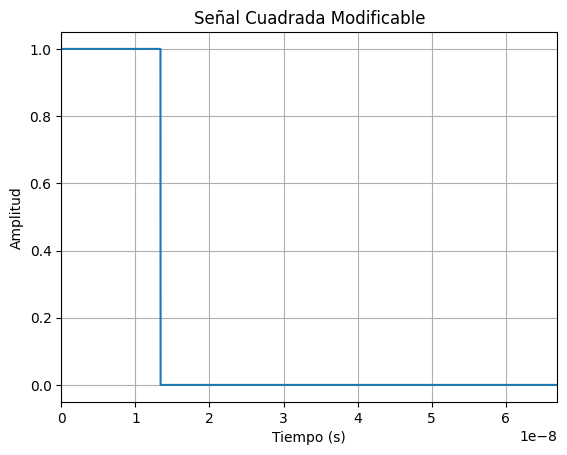

In [3]:
# Graficar
plt.plot(t, signal_square)
plt.title('Señal Cuadrada Modificable')
plt.xlabel('Tiempo (s)')
plt.xlim(0, PRI)
plt.ylabel('Amplitud')
plt.grid(True)
plt.show()

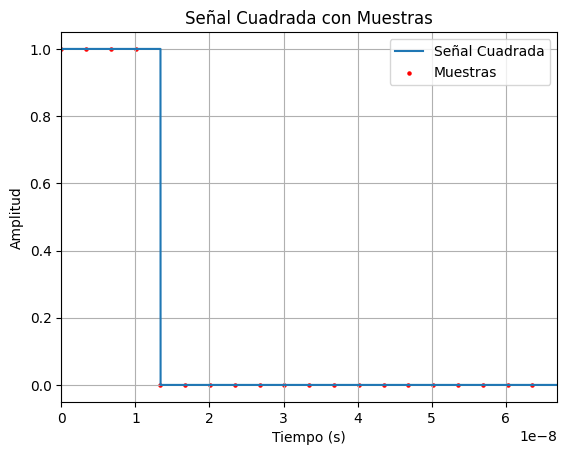

In [4]:
Fsampling = 20*PRF               # Frecuencia de muestreo. samplingRate >= 2 * PRF (frecuencia maxima de la señal)
Tsampling = 1 / Fsampling


# Elegir puntos de muestreo. samplingRateg >= 1/(2*PRF)
puntos_de_muestreo = np.arange(0, duracion, Tsampling)
Nmuestas = np.interp(puntos_de_muestreo, t, signal_square)

for m in range(len(Nmuestas)):
    if Nmuestas[m] > 0.0:
        Nmuestas[m] = 1
    else:
        Nmuestas[m] = 0

# Graficar la señal cuadrada y las muestras
plt.plot(t, signal_square, label='Señal Cuadrada')
plt.scatter(puntos_de_muestreo, Nmuestas, s=5 ,color='red', label='Muestras')
plt.title('Señal Cuadrada con Muestras')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.xlim((0, PRI))
plt.legend()
plt.grid(True)
plt.show()

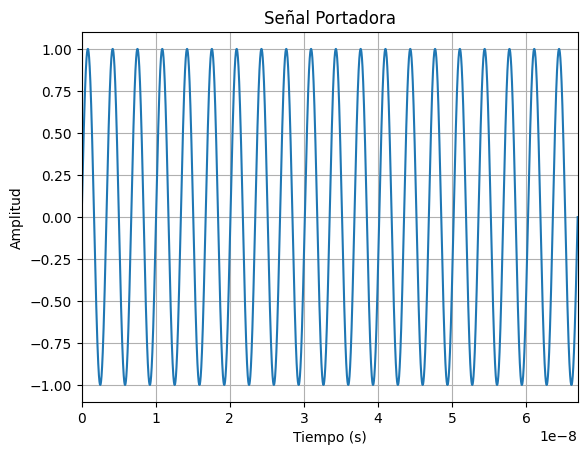

In [11]:
# Señal Portadora

# Parámetros de la señal
A = 1.0                 # Amplitud
f = PRF * 20            # Frecuencia de la señal (para una longitud de onda de 1 micrómetro)
T = 1/f
duration = PRI * 10     # Duración de la señal en segundos

# Crear el vector de tiempo
#ts = np.linspace(0, duration, Muestras, endpoint=False)

# Crear la señal sinusoidal
portadora = A * np.sin(2 * np.pi * f * t)

# Graficar la señal
plt.plot(t, portadora)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Señal Portadora')
plt.xlim(0, PRI)
plt.grid(True)
plt.show()

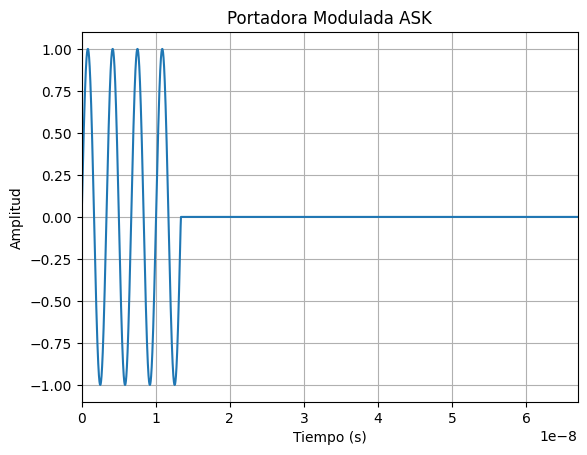

In [15]:
# Simulacion Señal a Transmitir

Tx = signal_square * portadora

# Graficar la señal
plt.plot(t, Tx)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Portadora Modulada ASK')
plt.xlim(0, PRI)
plt.grid(True)
plt.show()

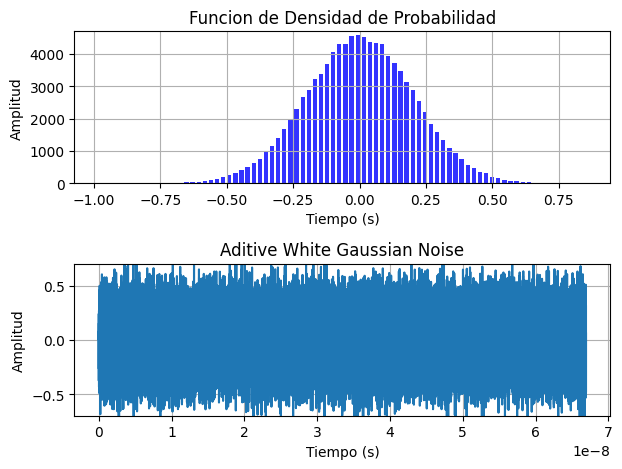

Tamaño de las muestas: 100000


In [16]:
#Modelado ruido AWGN(Additive White Gaussian Noise)
media = 0
d_estandar = 0.04
varianza = np.sqrt(d_estandar)
AWGN = np.random.normal(loc=media,scale=varianza, size=len(Tx))     # Se modela el ruido que queremos agregarle a la señal que cruza por el canal


# Graficar del histograma
plt.subplot(2, 1, 1)                                                # Subplot 2: 2 filas, 1 columna, segundo subplot
plt.hist(AWGN, rwidth=0.7 ,bins=80, color='blue', alpha=0.8)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.ylim(0, 4700)
plt.title('Funcion de Densidad de Probabilidad')
plt.grid(True)

# Graficar la señal
plt.subplot(2, 1, 2)                                                # Subplot 2: 2 filas, 1 columna, segundo subplot
plt.plot(t, AWGN)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.ylim(-0.7, 0.7)
plt.title('Aditive White Gaussian Noise')
plt.grid(True)

plt.tight_layout()                                                  # Ajustar automáticamente los subplots
plt.show()

print(f"Tamaño de las muestas: {len(Tx)}")

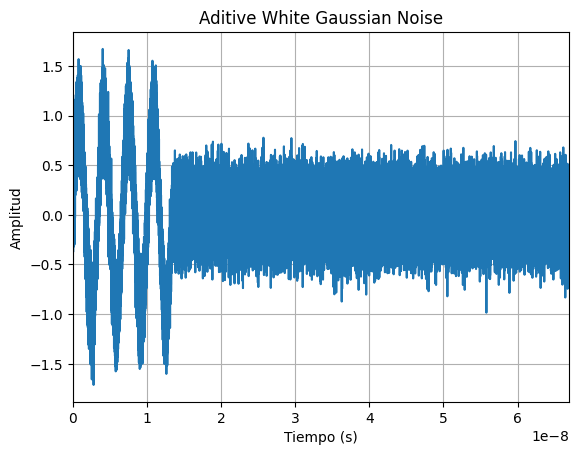

In [18]:
# Señal que entra al canal

signal_noise = Tx + AWGN                                # Señal a la cual se le agraga ruido

# Graficar la señal
plt.plot(t, signal_noise)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Aditive White Gaussian Noise')
plt.xlim(0, PRI)
plt.grid(True)
plt.show()

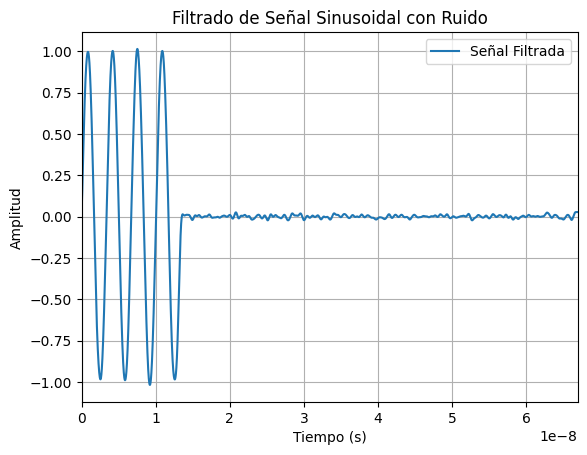

In [25]:
# Filtrar la señal con un filtro pasa bajos
fc = 100                                               # Frecuencia de corte del filtro pasa bajos en Hz
b, a = signal.butter(4, fc/(Muestras/2), 'low')         # Diseñar el filtro
filtered_signal = signal.filtfilt(b, a, signal_noise)

plt.plot(t, filtered_signal, label='Señal Filtrada')
plt.xlabel('Tiempo (s)')
plt.xlim(0, PRI)
plt.ylabel('Amplitud')
plt.title('Filtrado de Señal Sinusoidal con Ruido')
plt.legend()
plt.grid(True)
plt.show()

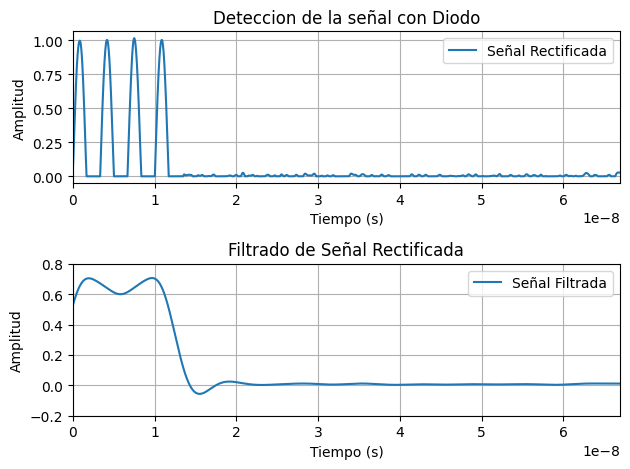

In [26]:
# Demodulacion y detección.

# Rectificación de onda media usando un diodo
rectified_signal = np.maximum(0, filtered_signal)                           # Se retienen solo las partes positivas de la señal

# Filtrar la señal con un filtro pasa bajos
fc = 10                                                                     # Frecuencia de corte del filtro pasa bajos en Hz
b, a = signal.butter(4, fc/(Muestras/2), 'low')                             # Diseñar el filtro
filtered_rectified_signal = signal.filtfilt(b, a, rectified_signal) * 2

plt.subplot(2, 1, 1)
plt.plot(t, rectified_signal, label='Señal Rectificada')
plt.xlabel('Tiempo (s)')
plt.xlim(0, PRI)
plt.ylabel('Amplitud')
plt.title('Deteccion de la señal con Diodo')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t, filtered_rectified_signal, label='Señal Filtrada')
plt.xlabel('Tiempo (s)')
plt.xlim(0, PRI)
plt.ylabel('Amplitud')
plt.ylim(-0.2, 0.8)
plt.title('Filtrado de Señal Rectificada')
plt.legend()
plt.grid(True)

plt.tight_layout()                                                          # Ajustar automáticamente los subplots
plt.show()

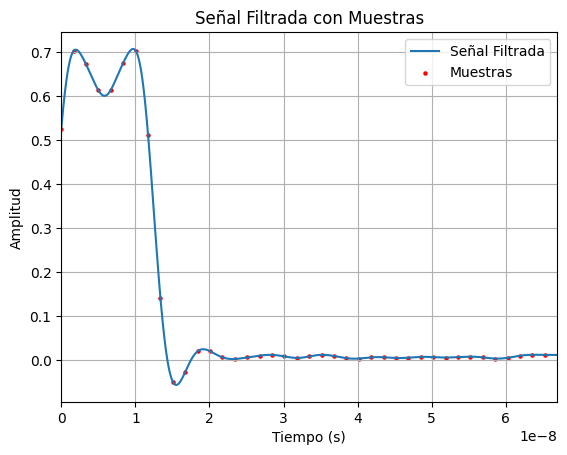

In [27]:
# Muestreo de la señal para un test de hipotesis

Fsampling = (20 * PRF) * 2              # Frecuencia de muestreo. samplingRate >= 2 * PRF * 20 (frecuencia maxima de la señal sinusoidal)
Tsampling = 1 / Fsampling


# Elegir puntos de muestreo. samplingRateg >= 1/(2*PRF)
puntos_de_muestreo = np.arange(0, duracion, Tsampling)
Nmuestas = np.interp(puntos_de_muestreo, t, filtered_rectified_signal)

#for m in range(len(Nmuestas)):
#    if Nmuestas[m] > 0.0:
#        Nmuestas[m] = 1
#    else:
#        Nmuestas[m] = 0

# Graficar la señal filtrada y las muestras
plt.plot(t, filtered_rectified_signal, label='Señal Filtrada')
plt.scatter(puntos_de_muestreo, Nmuestas, s=5 ,color='red', label='Muestras')
plt.title('Señal Filtrada con Muestras')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.xlim((0, PRI))
plt.legend()
plt.grid(True)
plt.show()